
# Global fit to all three K2 campaign lightcurves

and ASASSN! and ALL campaigns!

for a poster!

LET'S DO IT!!!

In [64]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# subsub K2

In [65]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [66]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

### Read in the ASASSN data.

In [67]:
usecols = ['HJD', 'flux(mJy)', 'flux_err', 'Filter']
df_ASASSN = pd.read_csv('../data/raw/ASASSN/S1063_ASASSN_20190123.csv', usecols=usecols)

# Tidy up the dataframe
df_ASASSN = df_ASASSN[df_ASASSN.flux_err!=99.990].reset_index(drop=True)
df_ASASSN.rename(columns={'flux(mJy)':'flux', 'HJD':'time'},inplace=True)
df_ASASSN['time'] = df_ASASSN['time'] - 2454833.0

# Focus on one filter at a time...
filt = 'V'
df_ASASSN = df_ASASSN[df_ASASSN.Filter == filt].reset_index(drop=True)[['time', 'flux', 'flux_err']]
const = np.percentile(df_ASASSN.flux, 80)

# Normalize
df_ASASSN['flux'] /=const
df_ASASSN['flux_err'] /=const

# drop outliers
good_mask = (df_ASASSN.flux > 0.7) & (df_ASASSN.time < 3500)
df_ASASSN = df_ASASSN[good_mask].reset_index(drop=True)

### THE ZEROPOINTS ARE SET HERE

In [68]:
# Here we retroactively assign the campaign zeropoints, which are not known a-priori.
C05_const, C16_const, C18_const = 76956.4/1.015, 73136.2, 77089.98/1.01 # iteratively computed at bottom.
dfC05['flux'] = dfC05['flux'] / C05_const
dfC16['flux'] = dfC16['flux'] / C16_const
dfC18['flux'] = dfC18['flux'] / C18_const

df = pd.concat([dfC05, dfC16, dfC18], ignore_index=True)

# df['flux'] = df.flux / np.percentile(df.flux, 98) Turn off if you normalize campaigns separately!
df['flux_err'] = df.flux *0.005

In [69]:
df_subset = df.sort_values('time').reset_index(drop=True)

In [70]:
t = df_subset.time.values
y = df_subset.flux
yerr = df_subset.flux_err

In [71]:
2.0 * np.pi / 23.5, 2.0 * np.pi / 13

(0.26736958753955686, 0.483321946706122)

In [72]:
import celerite
from celerite import terms

# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [73]:
%%time
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 40928.17825876015
CPU times: user 2.27 ms, sys: 908 µs, total: 3.18 ms
Wall time: 2.56 ms


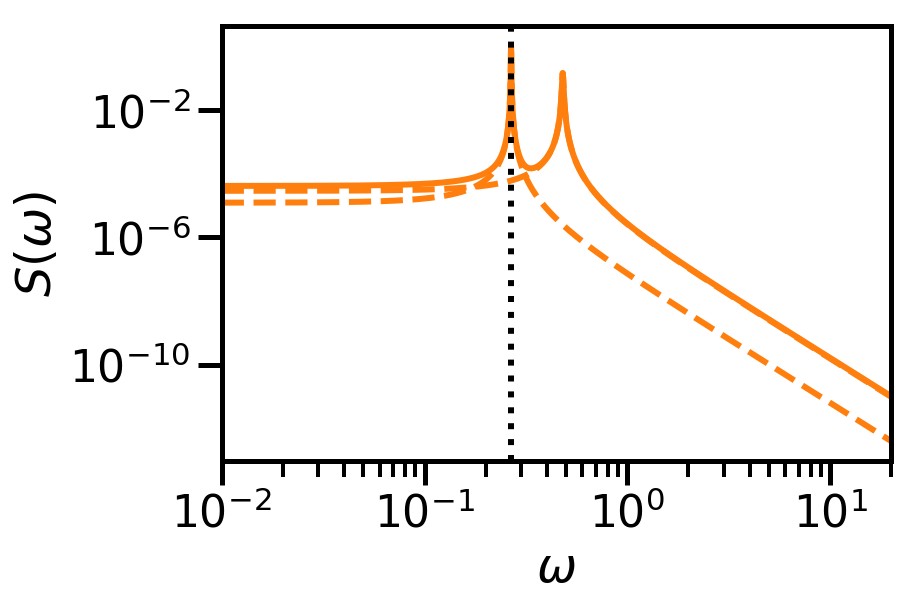

In [74]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)
color = "#ff7f0e"


plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [75]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -41138.57489467907
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.41327439,  1.77533366,  0.70867827,  0.95315045, -2.29338184])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 24
   status: 0
  success: True
        x: array([-6.99107147, -1.29896056, -8.17101315,  5.60823474, -1.29996077])


In [76]:
np.pi*2/10**-0.8290087063581993, np.pi*2/10**-1.3457165415991024

(42.382695572041094, 139.28245400025708)

In [77]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -6.991071467756616),
             ('kernel:terms[0]:log_omega0', -1.2989605591553246),
             ('kernel:terms[1]:log_S0', -8.171013149345018),
             ('kernel:terms[1]:log_Q', 5.6082347414833),
             ('kernel:terms[1]:log_omega0', -1.299960766766347)])

In [78]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

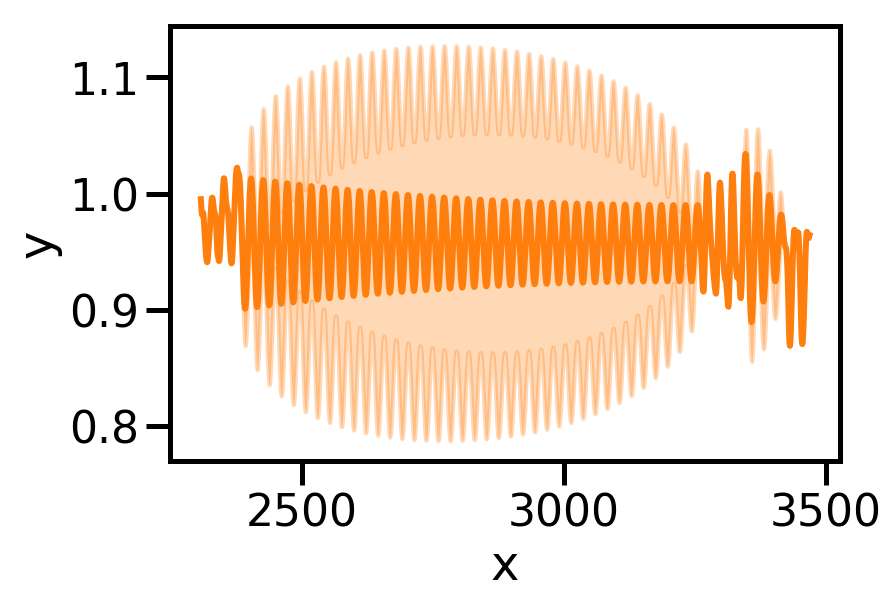

In [79]:
color = "#ff7f0e"
#plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

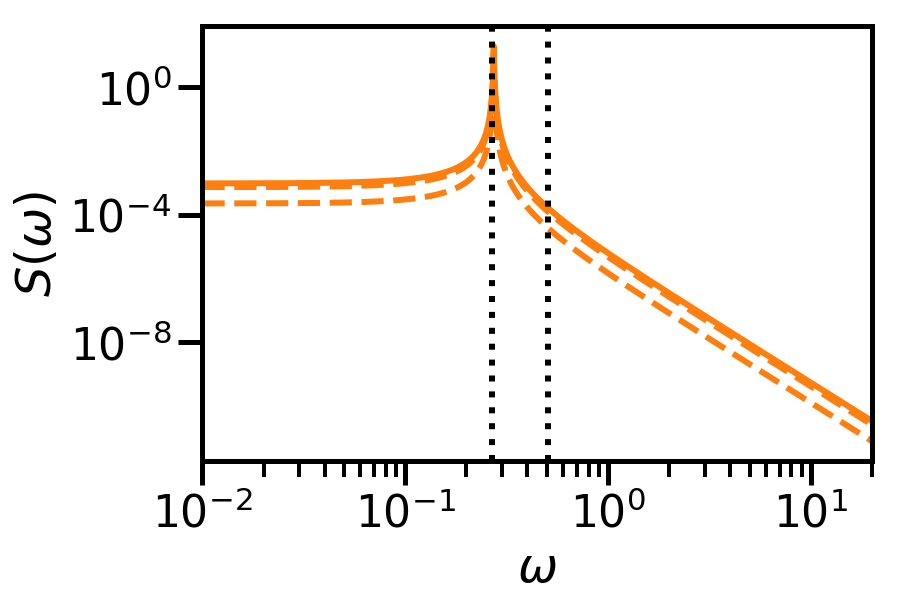

In [80]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')
plt.axvline(2.0*np.pi/12.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

## Now let's apply to the ASASSN data!

In [81]:
df_ASASSN = df_ASASSN.sort_values('time').reset_index(drop=True)

In [82]:
t = df_ASASSN.time.values
y = df_ASASSN.flux
yerr = df_ASASSN.flux_err

In [83]:
gp.get_parameter_vector()

array([-6.99107147, -1.29896056, -8.17101315,  5.60823474, -1.29996077])

In [84]:
# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [85]:
%%time
gp2 = celerite.GP(kernel, mean=np.mean(y))
gp2.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y)))

Initial log likelihood: 1014.773382604715
CPU times: user 1.14 ms, sys: 583 µs, total: 1.72 ms
Wall time: 1.19 ms


Text(0, 0.5, 'y')

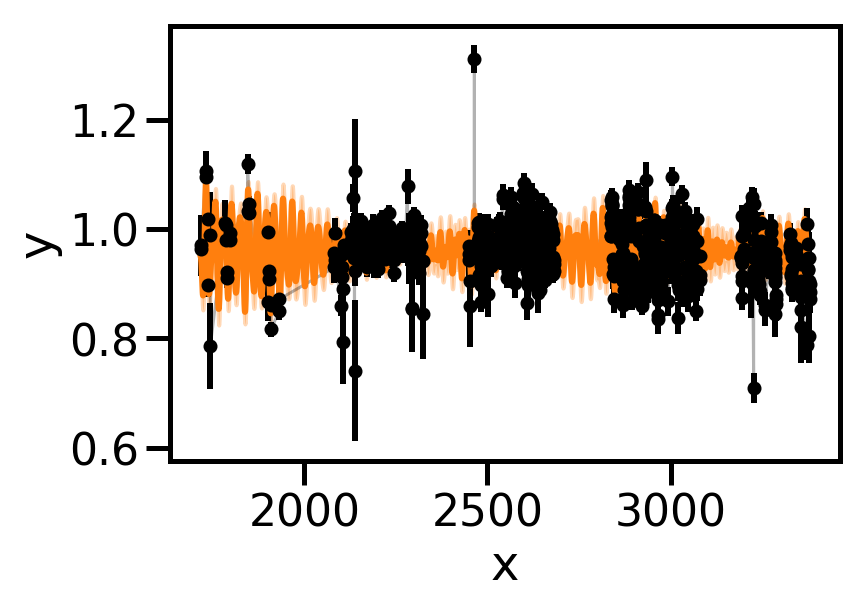

In [86]:
x = np.arange(df_ASASSN.time.iloc[0], df_ASASSN.time.iloc[-1], 1.0/2.0) # HALF DAY SAMPLING!
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

Let's transfer the GP parameters from K2:

In [87]:
gp2.set_parameter_vector(gp.get_parameter_vector())

CPU times: user 3.93 s, sys: 476 ms, total: 4.41 s
Wall time: 3.31 s


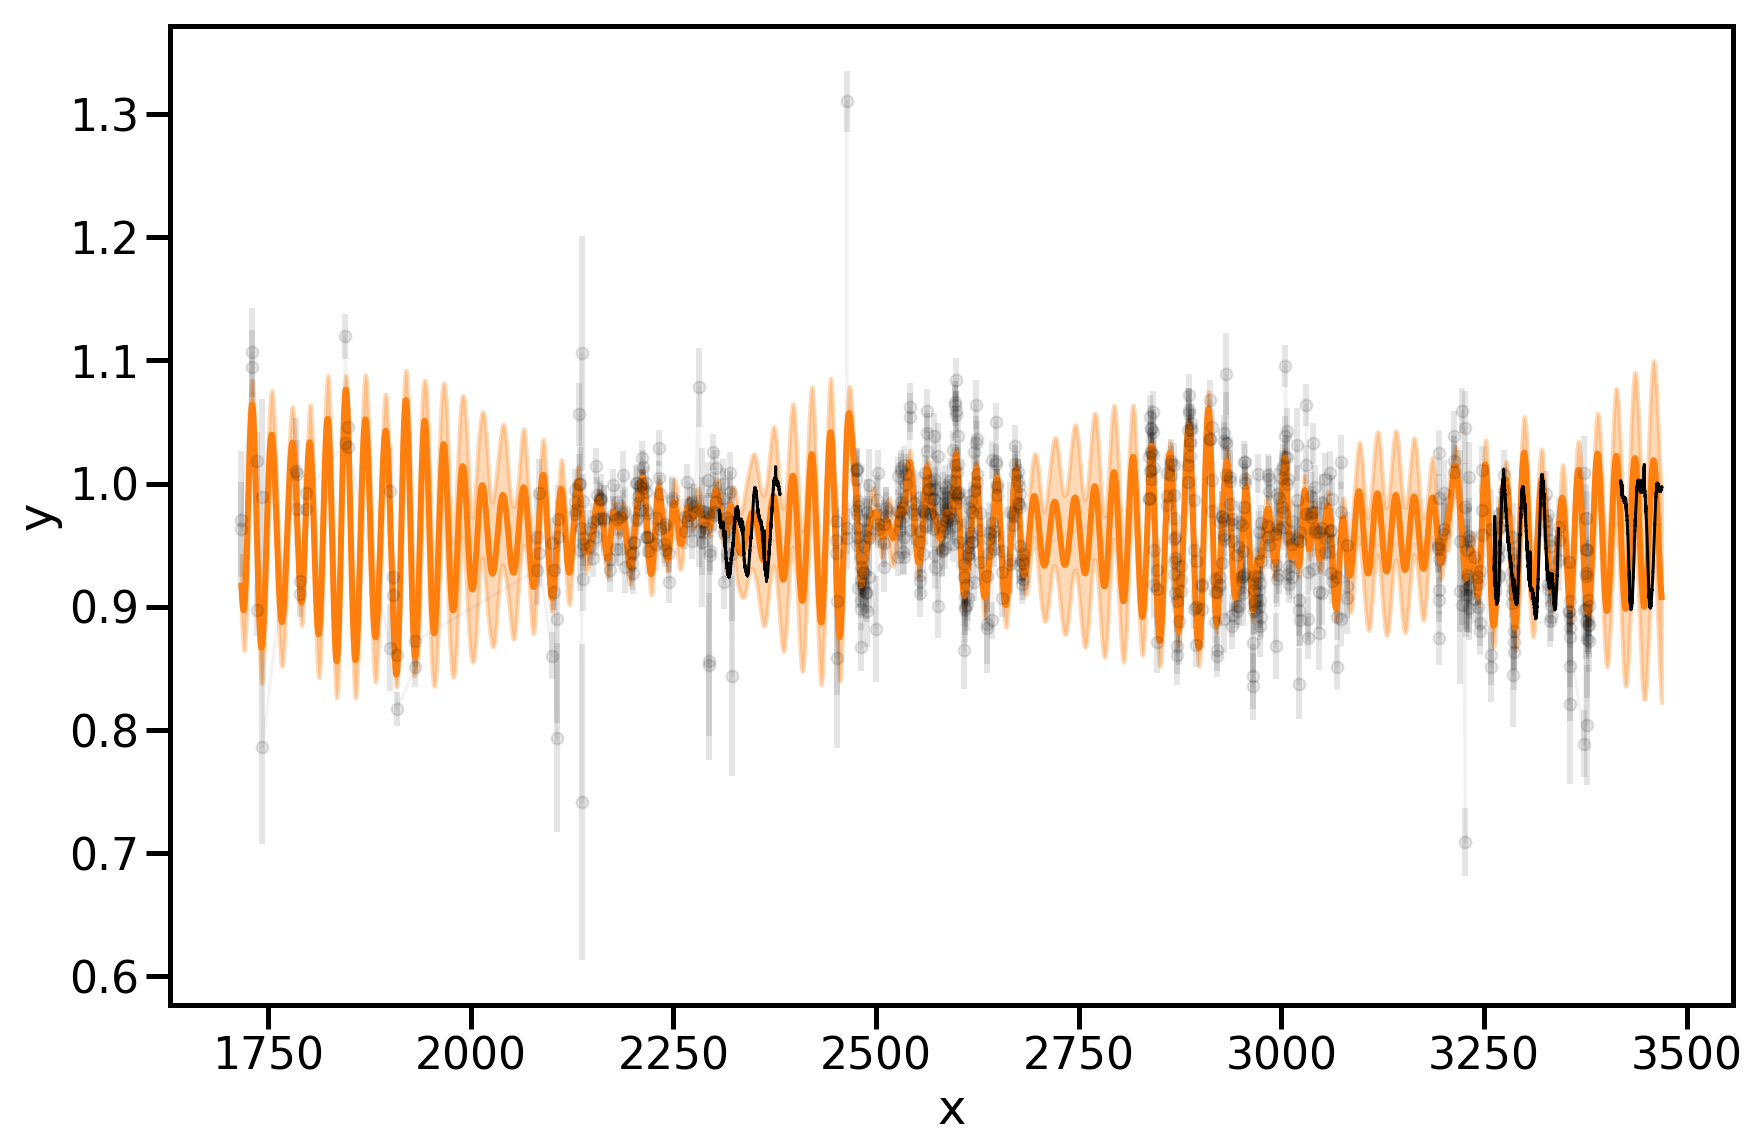

In [88]:
%%time
plt.figure(figsize=(14, 9))
x = np.arange(df_ASASSN.time.iloc[0], df.time.iloc[-1], 1.0/2.0) #half-day sampling
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_mean_K2, pred_var_K2 = gp.predict(df.flux.values, x, return_var=True)
pred_std = np.sqrt(pred_var)
pred_std_K2 = np.sqrt(pred_var_K2)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "k", lw=1.5, alpha=1)
plt.plot(dfC16.time, dfC16.flux/np.nanpercentile(dfC16.flux, 95), "k", lw=1.5, alpha=1)
plt.plot(dfC18.time, dfC18.flux/np.nanpercentile(dfC18.flux, 95), "k", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

(2000, 2750)

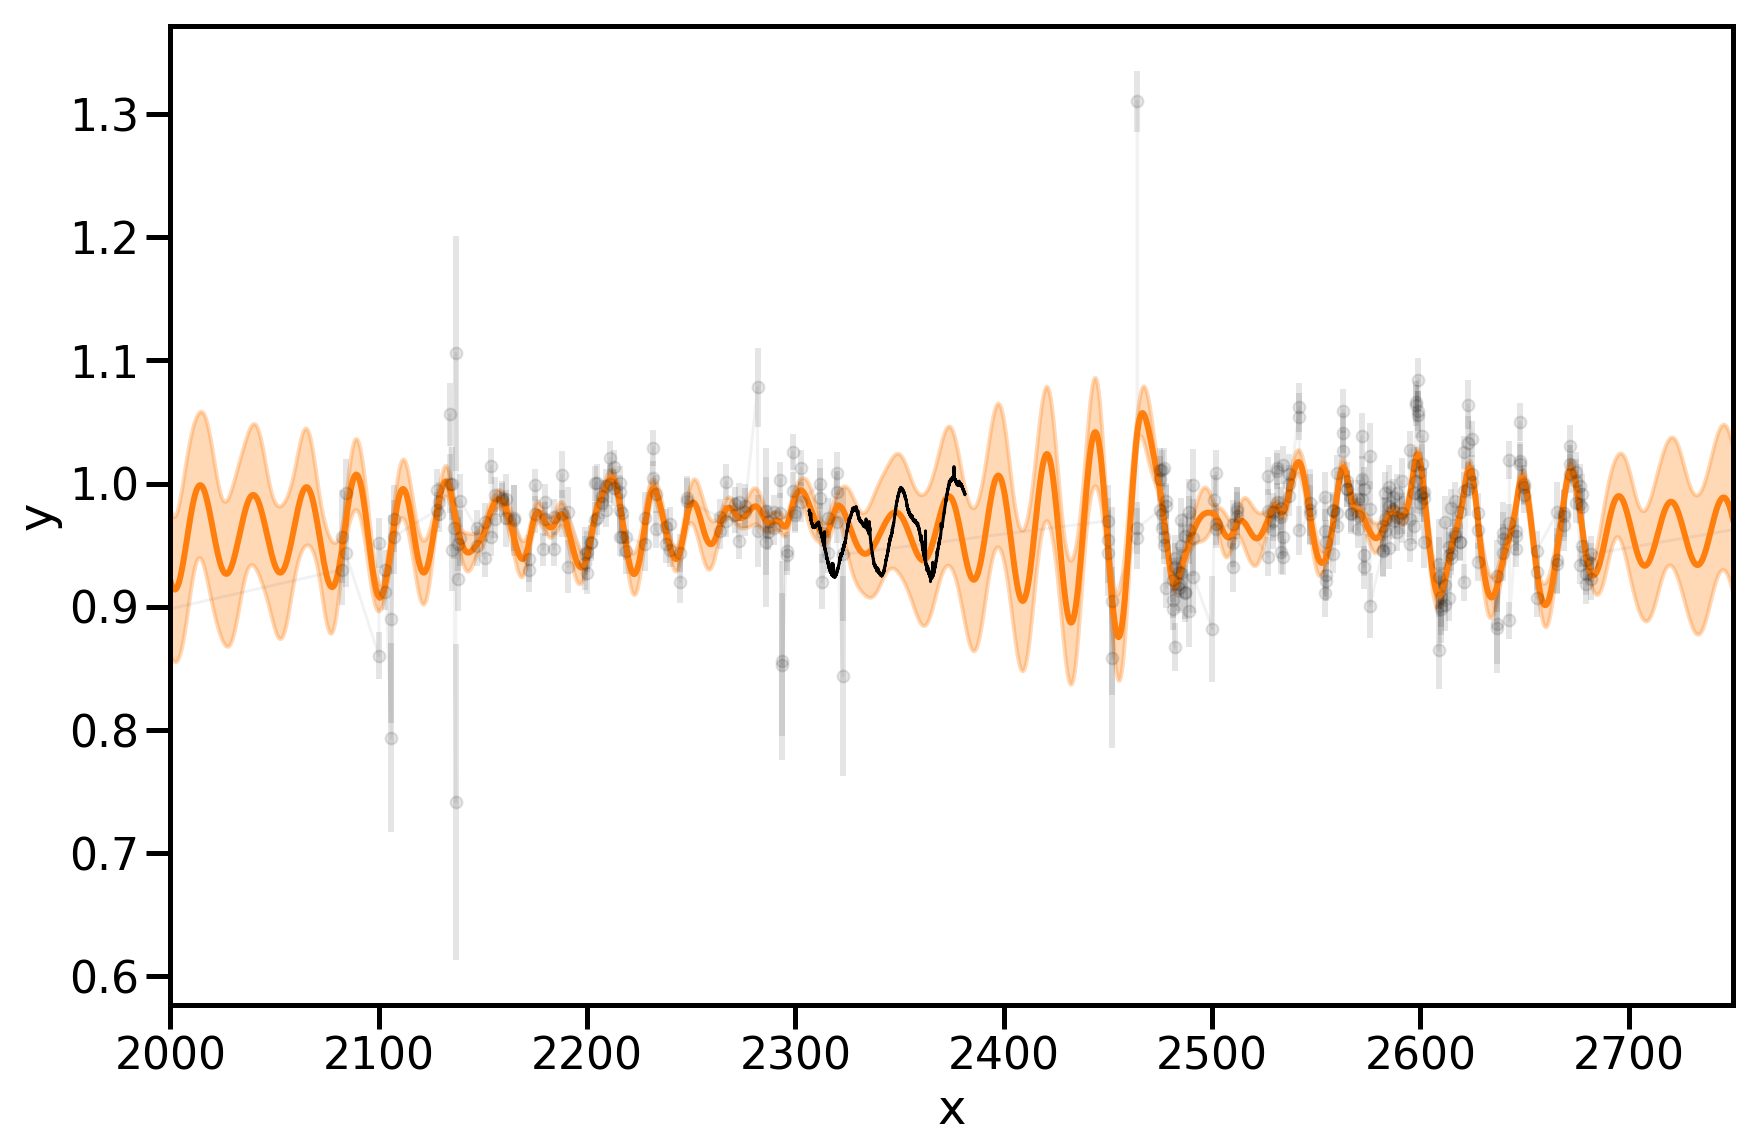

In [89]:
plt.figure(figsize=(14, 9))

plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "k", lw=1.5, alpha=1)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(2000, 2750)

(3000, 3556.99332717451)

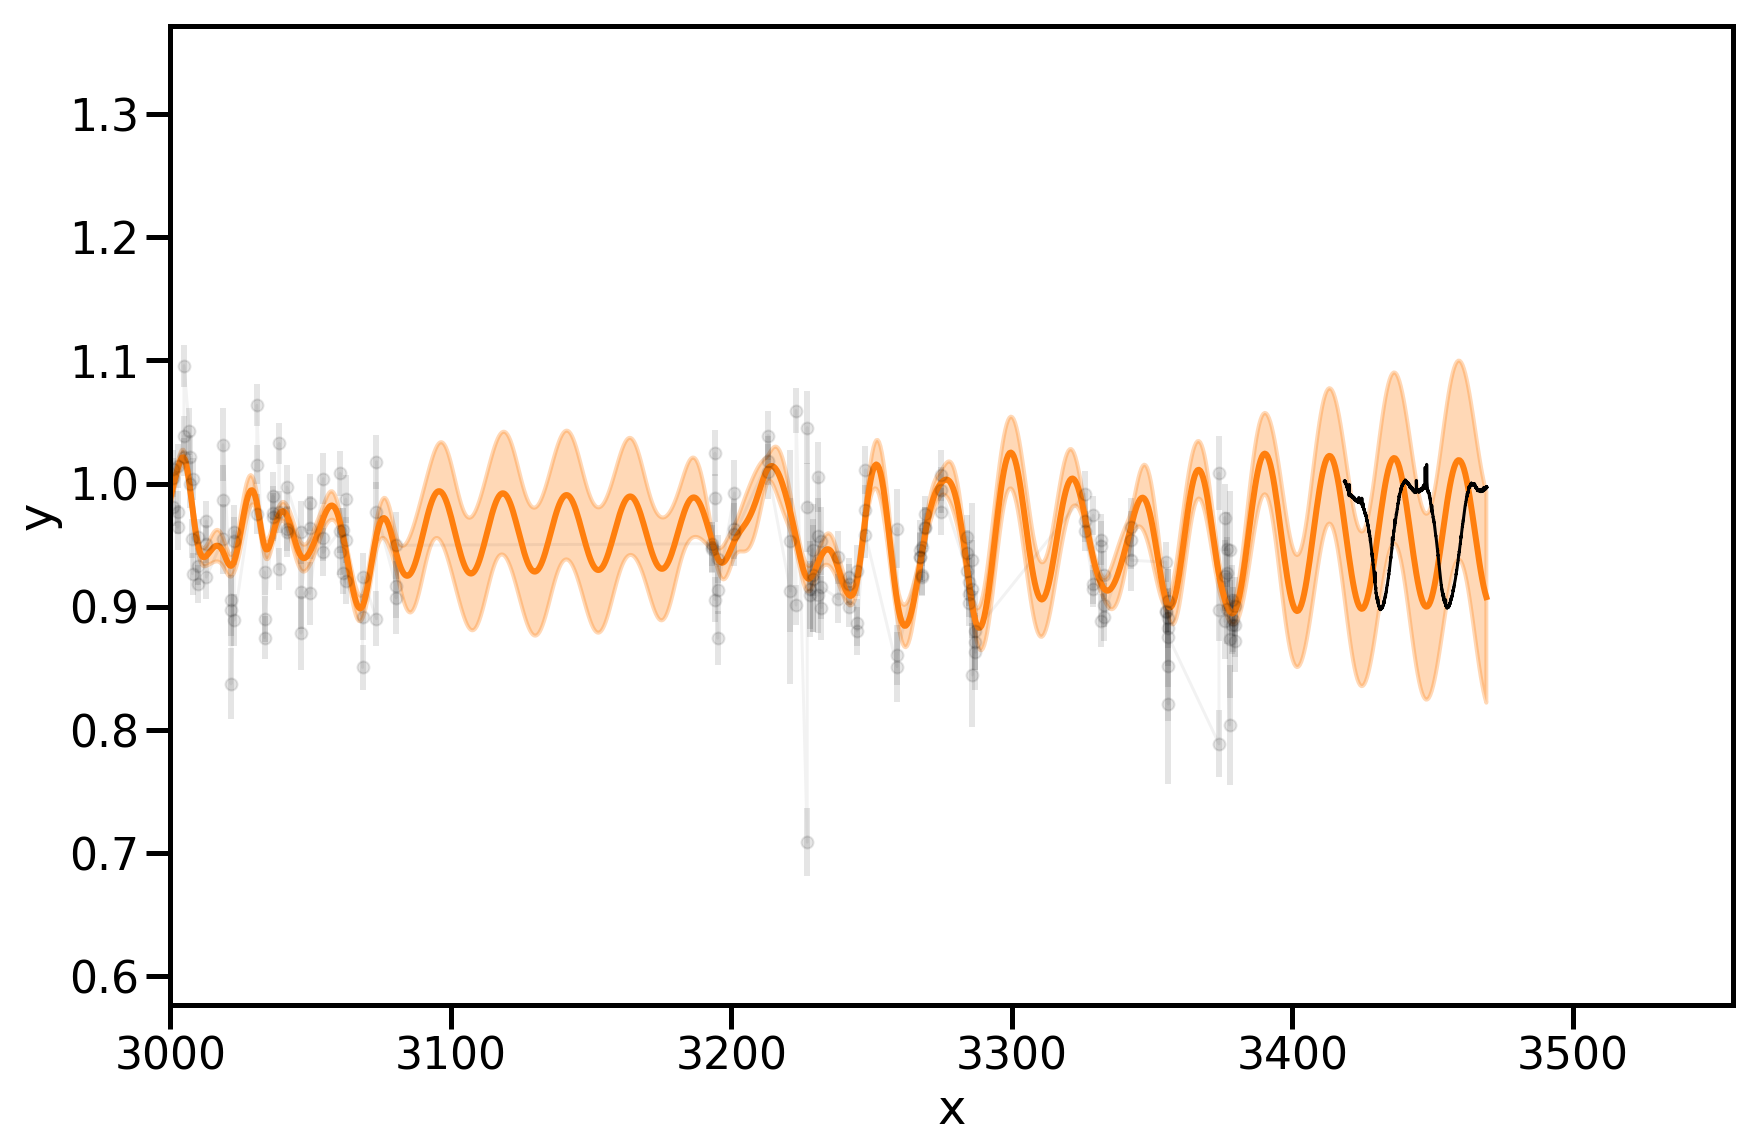

In [90]:
plt.figure(figsize=(14, 9))

plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC18.time, dfC18.flux/np.nanpercentile(dfC18.flux, 95), "k", lw=1.5, alpha=1)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(3000)

CPU times: user 70.7 ms, sys: 6.4 ms, total: 77.1 ms
Wall time: 76.1 ms


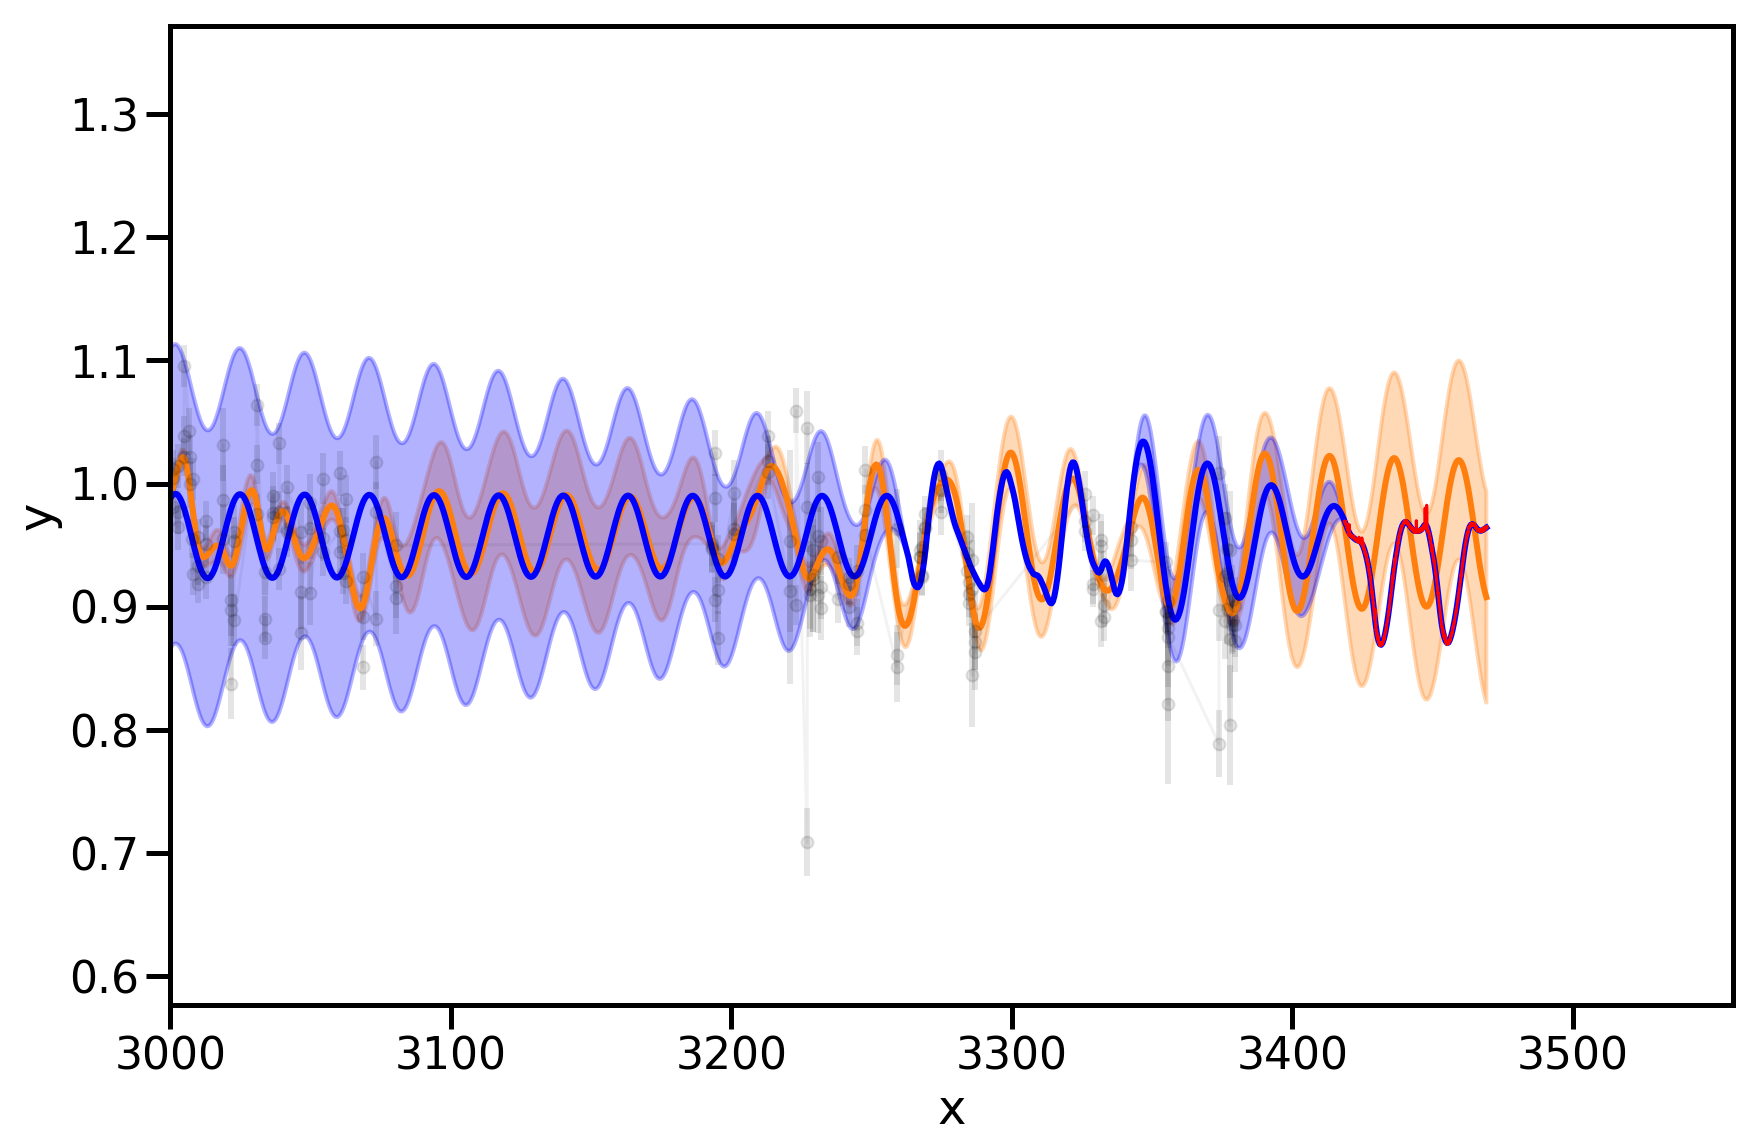

In [91]:
%%time
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
                 edgecolor="none")

plt.plot(dfC18.time, dfC18.flux, "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(3000)

In [92]:
def compute_K2_zeropoints(df_K2_campaign):
    '''compute the K2 flux absolute value per campaign'''
    df_K2_campaign.time
    x = df_K2_campaign.time.values
    pred_mean, pred_var = gp2.predict(y, x, return_var=True)
    ratio = np.median(df_K2_campaign.flux/pred_mean)
    return ratio

In [93]:
compute_K2_zeropoints(dfC05), compute_K2_zeropoints(dfC16), compute_K2_zeropoints(dfC18)

(1.015911499731077, 0.9997043082800559, 0.992217258754371)

## Publication quality version

In [94]:
from astropy.time import Time
times = ['2014-01-01T00:00:00.0', '2015-01-01T00:00:00.0', 
         '2016-01-01T00:00:00.0', '2017-01-01T00:00:00.0', '2018-01-01T00:00:00.0']
#times = ['2018-01-01T00:00:00.0']
nye_t = Time(times, format='isot', scale='utc')

nye_tick_locations = nye_t.jd - 2454833
#nye_t.decimalyear

In [95]:
import seaborn as sns
sns.set_context("poster")

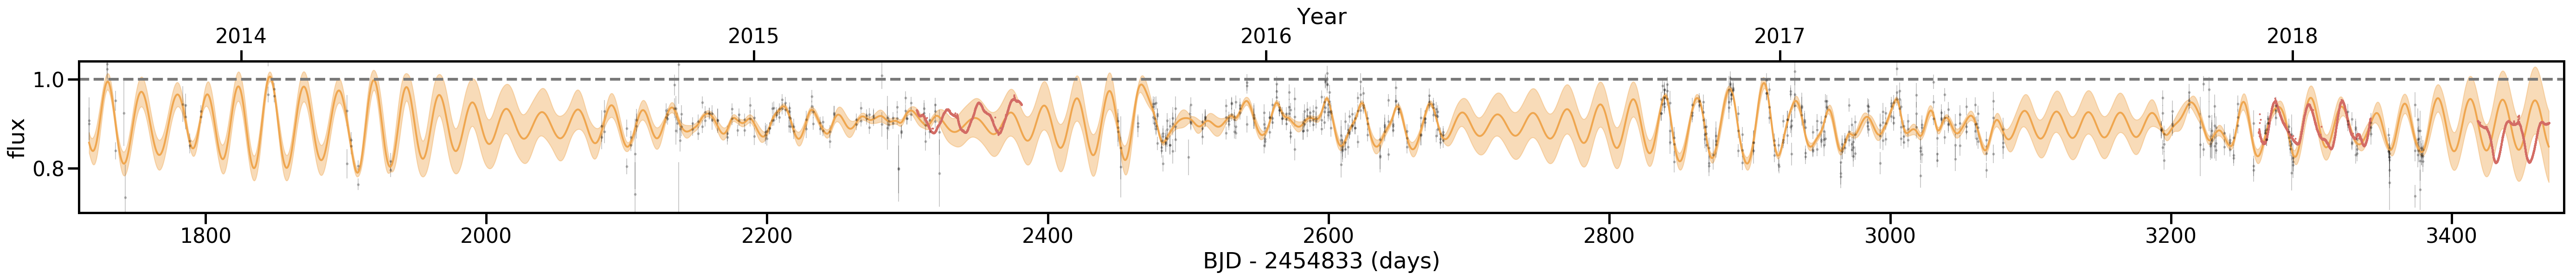

In [96]:
#%%time
fig = plt.figure(figsize=(48, 3))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

peak = 1.07

color = "#EFA64F"
ax1.errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=4, capsize=0, alpha=0.2, lw=1, label='ASASSN $V$')
ax1.plot(x, pred_mean/peak, color=color, lw=2)
ax1.fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.4,
                 edgecolor="none", lw=1)

ax1.plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=2)
ax1.plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=2, label='K2: C5, C16, C18')



ax1.axhline(1.0, linestyle='dashed', color='#797979')

ax1.set_xlabel("BJD - 2454833 (days)")
ax1.set_ylabel("flux")
ax1.set_ylim(0.7, 1.04)
ax1.set_xlim(1710, 3480)
#ax1.set_xlim(3200, 3470)

#ax1.legend(loc='lower left')
#ax1.legend(bbox_to_anchor=(0.95, 0.95))

ax2.set_xlim(1710, 3480)
#ax2.set_xlim(3200, 3470)
ax2.set_xticks(nye_tick_locations)
ax2.set_xticklabels(nye_t.decimalyear.astype(np.int))
ax2.set_xlabel("Year")


plt.savefig('../document/figures/five_year_lightcurve_V_poster.pdf', bbox_inches='tight', dpi=300, transparent=True)

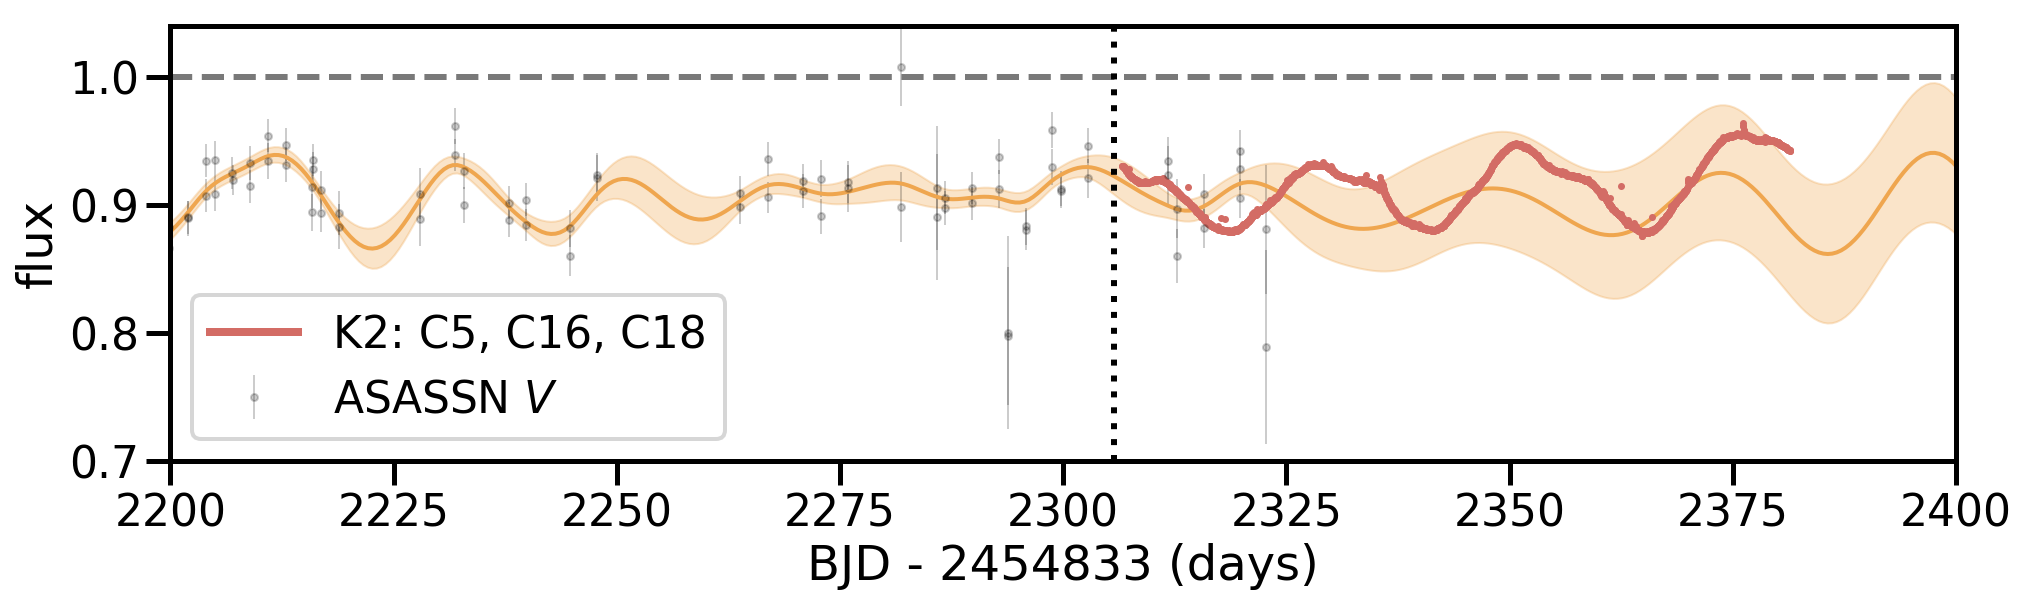

In [98]:
import seaborn as sns
sns.set_context("poster")


#%%time
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()

peak = 1.07

igrins_obs = 57138.64 - 54833

color = "#EFA64F"
ax1.errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=7, capsize=0, alpha=0.2, lw=1, label='ASASSN $V$')
ax1.plot(x, pred_mean/peak, color=color, lw=2)
ax1.fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.3,
                 edgecolor="none", lw=1)

ax1.plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=5)
ax1.plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=4, label='K2: C5, C16, C18')

ax1.axhline(1.0, linestyle='dashed', color='#797979')
ax1.axvline(igrins_obs, linestyle='dotted', color='k')

#ax1.axhline(0.93, linestyle='dashed', color='#783891')

ax1.set_xlabel("BJD - 2454833 (days)")
ax1.set_ylabel("flux")
ax1.set_ylim(0.7, 1.04)
#ax1.set_xlim(1717, 3470)
ax1.set_xlim(2200, 2400)
#ax1.set_xlim(3200, 3470)

ax1.legend(loc='lower left')

#ax2.set_xlim(2200, 2400)
#ax2.set_xlim(1717, 3470)
#ax2.set_xlim(3200, 3470)
#ax2.set_xticks(nye_tick_locations)
#ax2.set_xticklabels(nye_t.decimalyear.astype(np.int))
#ax2.set_xlabel("Year")


plt.savefig('../document/figures/c5_lightcurve_V_poster.pdf', bbox_inches='tight', dpi=300, transparent=True)

In [34]:
df_ASASSN.time.iloc[0], df.time.iloc[-1]

(1717.1368599999696, 3469.3811144519127)

The end!